In [173]:
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si
import pandas as pd 
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

In [174]:
# fill nan value with average
def fillNan(m):

    rows=len(m) 
    columns=m.shape[1]
 
    for j in range(0,columns):
        if m.columns[j] == 'date':
            continue
        m[m.columns[j]] = pd.to_numeric(m[m.columns[j]])
        sum1=0.0
        count=0.0
        for i in range(0,rows):
            if not (pd.isna(m[m.columns[j]][i])):
                sum1+=float(m[m.columns[j]][i])
                count+=1
        # in case all nan value 
        avg=sum1/max(count,1)
        for i in range(0,rows):
            if pd.isna(m[m.columns[j]][i]) or (float(m[m.columns[j]][i])==0):
                m[m.columns[j]][i]=avg
    return m

In [175]:
#use mad delete extreme value
def MAD(dataset, n):
    median = np.median(dataset)  # 中位数
    deviations = abs(dataset - median)
    mad = np.median(deviations)
 
    remove_idx = np.where(abs(dataset - median) >  n * mad)
    new_data = np.delete(dataset, remove_idx)
 
    return new_data
# normalization data
def Normalization(x):
    return [(float(i)-min(x))/float(max(x)-min(x)) for i in x]

In [176]:
def clean(ticker,url):
    #get df of stock
    df = pd.read_csv(url, index_col=0)
    
    stock_data = get_data(ticker, start_date="01/01/2010", end_date="07/10/2021", index_as_date = True, interval="1mo")
    stock_data.index=stock_data.index.to_period("M")
    #add monthly log return column
    stock_data['log_return'] = np.log(stock_data['close']).diff()
    
    
    df=df.drop(['open','high','low','close','adjclose','volume','ticker'],axis=1)
    df.index = pd.to_datetime(df.index)
    df.index = df.index.to_period('M')
    df = df.join(stock_data)
    
    #drop the columns when all rows of this columns are all nan
    df=df.dropna(how='all',axis=1)
    df = df.replace(',','', regex=True)
    df.columns = df.columns.str.replace('\t', '')
    df=df.drop(['open','close','high','low','ticker'],axis=1)
    df = fillNan(df)
    df['adjclose'] = MAD(df['adjclose'],n=5)
    #df['adjclose'] = Normalization(df['adjclose'])
    if 'Cushing OK WTI Spot Price FOB Dollars per Barrel' in df.columns:
        df=df.rename({'Cushing OK WTI Spot Price FOB Dollars per Barrel' : 'OilPrice'}, axis=1)
    return df

In [177]:
# get dataframe after cleaning 
data=clean('aal', 'https://raw.githubusercontent.com/GaoleL/Data_project/main/Data/aal_macro.csv')
data = data.iloc[::-1]
data['adjclose'].head()

<ipython-input-174-98646b20a799>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m[m.columns[j]][i]=avg


date
2010-03    6.929150
2010-06    8.117004
2010-09    8.720360
2010-12    9.436843
2011-03    8.211280
Freq: M, Name: adjclose, dtype: float64

In [178]:
#Variance inflation factor (VIF)
def vif(df, col_i):
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)


In [179]:
# factors maybe change based on different stocks, eg. some stocks has surgar price data, some are not
test_data = data[['OperatingRevenue', 'CostOfRevenue', 'OperatingExpense',
'NetNonOperatingInterestIncomeExpense', 
        'TaxProvision','NetIncome',
       'BasicEPS',  'BasicAverageShares', 
       'TotalOperatingIncomeAsReported', 'RentExpenseSupplemental',
       'TotalExpenses', 
       'NormalizedIncome', 'InterestIncome', 'InterestExpense',
       'NetInterestIncome', 'EBIT',  
       'TotalUnusualItems',
        'TaxEffectOfUnusualItems',
        'volume', 'MarketCap',
       'EnterpriseValue', 'PeRatio', 'PegRatio', 'PsRatio',
       'PbRatio'
       
    ]]


efficient_col=[]
for i in test_data.columns:
    print(i, '\t', vif(test_data, col_i=i))
    if float(vif(test_data,col_i=i))<20:
        efficient_col.append(i)

# check if there is an zero 
# test_data.all(axis='columns')
test_data.isnull().sum()

OperatingRevenue 	 187.98803946578442
CostOfRevenue 	 inf
OperatingExpense 	 inf
NetNonOperatingInterestIncomeExpense 	 inf
TaxProvision 	 inf


<ipython-input-178-6216a0607cca>:8: RuntimeWarning: divide by zero encountered in double_scalars
  return 1. / (1. - r2)


NetIncome 	 inf
BasicEPS 	 13.532651075724422
BasicAverageShares 	 34.27874878999008
TotalOperatingIncomeAsReported 	 96.57419906078333
RentExpenseSupplemental 	 112.40182216843262
TotalExpenses 	 inf
NormalizedIncome 	 inf
InterestIncome 	 inf
InterestExpense 	 inf
NetInterestIncome 	 inf
EBIT 	 inf
TotalUnusualItems 	 inf
TaxEffectOfUnusualItems 	 inf
volume 	 8.243766160068372
MarketCap 	 109.59310038809022
EnterpriseValue 	 80.81267448002907
PeRatio 	 6.727750911185539
PegRatio 	 1.2600420136272779
PsRatio 	 29.826684203015457
PbRatio 	 1.582663812958008


OperatingRevenue                        0
CostOfRevenue                           0
OperatingExpense                        0
NetNonOperatingInterestIncomeExpense    0
TaxProvision                            0
NetIncome                               0
BasicEPS                                0
BasicAverageShares                      0
TotalOperatingIncomeAsReported          0
RentExpenseSupplemental                 0
TotalExpenses                           0
NormalizedIncome                        0
InterestIncome                          0
InterestExpense                         0
NetInterestIncome                       0
EBIT                                    0
TotalUnusualItems                       0
TaxEffectOfUnusualItems                 0
volume                                  0
MarketCap                               0
EnterpriseValue                         0
PeRatio                                 0
PegRatio                                0
PsRatio                           

In [182]:
# Regression with adjclose price
X = test_data # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = data['adjclose']
X = sm.add_constant(X)
est = sm.OLS(Y, X.astype(float)).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     89.63
Date:                Thu, 05 Aug 2021   Prob (F-statistic):           2.58e-17
Time:                        12:10:20   Log-Likelihood:                -86.338
No. Observations:                  45   AIC:                             216.7
Df Residuals:                      23   BIC:                             256.4
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   10.3867      7.731      1.344      0.192      -5.606      26.379
OperatingRevenue                     -5.818e-09    1.9e-09     -3.060      0.006   -9.75e-09   -1.89e-09
CostOfRevenue                         7.176e-06   5.74e-05      0.125      0.902      -0.000       0.000
OperatingExpense                      7.178e-06   5.74e-05      0.125      0.902      -0.000       0.000
NetNonOperatingInterestIncomeExpense  3.869e-06   3.05e-05      0.127      0.900   -5.92e-05    6.69e-05
TaxProvision                         -6.527e-07   5.44e-06     -0.120      0.906   -1.19e-05    1.06e-05
NetIncome                              8.72e-07   6.28e-06      0.139      0.891   -1.21e-05    1.39e-05
BasicEPS                                 1.6329      0.395      4.130      0.000       0.815       2.451
BasicAverageShares                   -4.301e-08   9.66e-09     -4.452      0.000    -6.3e-08    -2.3e-08
TotalOperatingIncomeAsReported        3.703e-09   2.98e-09      1.244      0.226   -2.45e-09    9.86e-09
RentExpenseSupplemental              -1.646e-08   1.83e-08     -0.900      0.378   -5.43e-08    2.14e-08
TotalExpenses                         -7.17e-06   5.74e-05     -0.125      0.902      -0.000       0.000
NormalizedIncome                     -1.526e-06   1.17e-05     -0.130      0.898   -2.58e-05    2.27e-05
InterestIncome                       -1.481e-06   1.34e-05     -0.111      0.913   -2.92e-05    2.62e-05
InterestExpense                       1.172e-06   7.96e-06      0.147      0.884   -1.53e-05    1.76e-05
NetInterestIncome                    -2.088e-06   1.71e-05     -0.122      0.904   -3.75e-05    3.33e-05
EBIT                                  6.529e-07   5.45e-06      0.120      0.906   -1.06e-05    1.19e-05
TotalUnusualItems                    -1.537e-06   1.17e-05     -0.131      0.897   -2.58e-05    2.27e-05
TaxEffectOfUnusualItems               1.566e-06   1.17e-05      0.133      0.895   -2.27e-05    2.58e-05
volume                                -1.42e-09    1.8e-09     -0.787      0.439   -5.15e-09    2.31e-09
MarketCap                             1.681e-09   3.27e-10      5.142      0.000       1e-09    2.36e-09
EnterpriseValue                       7.742e-11   1.98e-10      0.392      0.699   -3.32e-10    4.86e-10
PeRatio                                 -0.3325      0.358     -0.928      0.363      -1.074       0.409
PegRatio                                 4.1715      2.736      1.525      0.141      -1.487       9.830
PsRatio                                 -0.6323      7.206     -0.088      0.931     -15.539      14.274
PbRatio                                 -0.0308      0.041     -0.760      0.455      -0.115       0.053
======================================

In [183]:
# Y.index = Y.index.to_timestamp()
# plt.plot(Y)

In [184]:
# Pick three of them 
lm = ols('adjclose ~ OperatingRevenue + BasicEPS  + MarketCap', data=data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     127.6
Date:                Thu, 05 Aug 2021   Prob (F-statistic):           7.96e-21
Time:                        12:10:26   Log-Likelihood:                -133.17
No. Observations:                  45   AIC:                             274.3
Df Residuals:                      41   BIC:                             281.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.9165      2.794      1.044      0.303      -2.726       8.559
OperatingRevenue  1.171e-09      4e-10      2.926      0.006    3.63e-10    1.98e-09
BasicEPS             0.1358      0.275      0.493      0.624      -0.420       0.692
MarketCap         1.089e-09   8.95e-11     12.157      0.000    9.08e-10    1.27e-09
==============================================================================
Omnibus:                        2.223   Durbin-Watson:                   0.541
Prob(Omnibus):                  0.329   Jarque-Bera (JB):                1.725
Skew:                           0.310   Prob(JB):                        0.422
Kurtosis:                       2.268   Cond. No.                     7.21e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.21e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [189]:
#use efficient columns (VIF less than 20)
X = data[efficient_col] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = data['adjclose']
X = sm.add_constant(X)
est = sm.OLS(Y, X.astype(float)).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               adjclose   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     4.241
Date:                Thu, 05 Aug 2021   Prob (F-statistic):            0.00356
Time:                        12:14:19   Log-Likelihood:                -175.95
No. Observations:                  45   AIC:                             363.9
Df Residuals:                      39   BIC:                             374.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5287     10.326      1.020      0.314     -10.358      31.415
BasicEPS       2.4254      0.654      3.707      0.001       1.102       3.749
volume      1.397e-10   3.84e-09      0.036      0.971   -7.64e-09    7.91e-09
PeRatio        1.3225      0.785      1.685      0.100      -0.265       2.910
PegRatio      14.5993     14.135      1.033      0.308     -13.991      43.190
PbRatio       -0.1785      0.187     -0.954      0.346      -0.557       0.200
==============================================================================
Omnibus:                        5.382   Durbin-Watson:                   0.794
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                2.459
Skew:                          -0.272   Prob(JB):                        0.293
Kurtosis:                       1.992   Cond. No.                     5.42e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.42e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

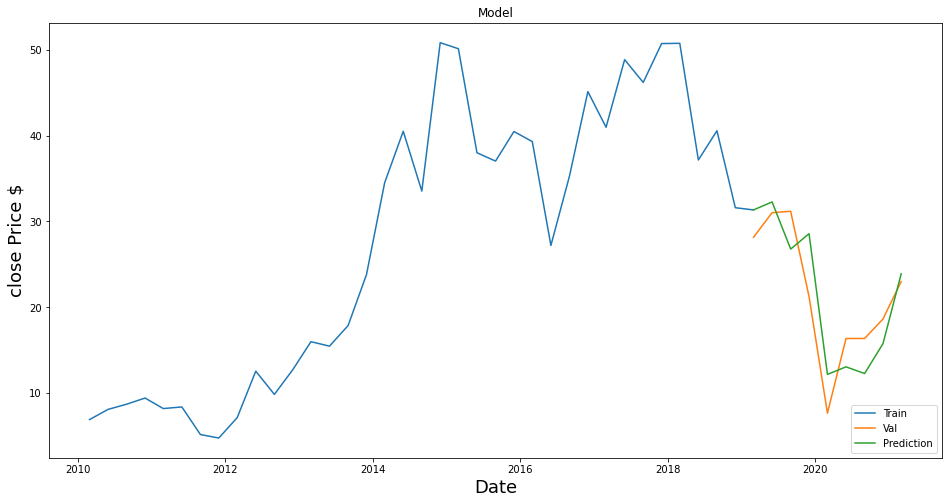

In [195]:
# use efficient columns to make predict
train_x = X[:int(0.8*len(X))+1]
train_y = Y[:int(0.8*len(Y))+1]

test_x = X[int(0.8*len(X)):]
test_y = Y[int(0.8*len(Y)):]

y_pred = est.predict(test_x)

df=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})
df.index = df.index.to_timestamp()
train_y.index = train_y.index.to_timestamp()
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('close Price $',fontsize=18)
plt.plot(train_y)
plt.plot(df['Predicted'])
plt.plot(df['Actual'])
plt.legend(['Train','Val','Prediction'],loc='lower right')

In [191]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 3.5377107150876927
Mean Squared Error: 15.76264043589459
Root Mean Squared Error: 3.9702191924243415


In [192]:
errors = abs(y_pred - test_y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.54 degrees.
Accuracy: 80.71 %.


In [141]:
# Regression with LogRetrun
test_data = data[[ 'CostOfRevenue', 
        'TaxProvision',
       'BasicEPS',  'BasicAverageShares', 
       'TotalExpenses', 
       'NetInterestIncome', 'EBIT',  
       'TotalUnusualItems',
        'TaxEffectOfUnusualItems',
        'volume', 'MarketCap',
       'EnterpriseValue', 'PeRatio', 'PegRatio', 'PsRatio',
       'PbRatio', 'Inflation',
       'ExchangeRate', 'adjclose'
       
    ]]
       
for i in test_data.columns:
    print(i, '\t', vif(test_data, col_i=i))

# check if there is an zero 
# test_data.all(axis='columns')
test_data.isnull().sum()



CostOfRevenue 	 6.857846806168812
TaxProvision 	 2.7114346853632276
BasicEPS 	 11.620346782000366
BasicAverageShares 	 23.958137197796887
TotalExpenses 	 19.625224893520656
NetInterestIncome 	 4.811768644429913
EBIT 	 24.75097667630157
TotalUnusualItems 	 23.852381819110345
TaxEffectOfUnusualItems 	 23.10482441716428
volume 	 7.7375222033200695
MarketCap 	 86.82313029601379
EnterpriseValue 	 51.52259079727697
PeRatio 	 2.892221783424535
PegRatio 	 1.304301811560481
PsRatio 	 22.341874438356108
PbRatio 	 1.4712451071424764
Inflation 	 3.0658433670873233
ExchangeRate 	 4.332620143307031
adjclose 	 35.5521572290929


CostOfRevenue              0
TaxProvision               0
BasicEPS                   0
BasicAverageShares         0
TotalExpenses              0
NetInterestIncome          0
EBIT                       0
TotalUnusualItems          0
TaxEffectOfUnusualItems    0
volume                     0
MarketCap                  0
EnterpriseValue            0
PeRatio                    0
PegRatio                   0
PsRatio                    0
PbRatio                    0
Inflation                  0
ExchangeRate               0
adjclose                   0
dtype: int64

In [221]:



X = test_data
for i in X.columns:
    X[i] = Normalization(X[i])
# here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = data['log_return']
X = sm.add_constant(X)
print(Y)
est = sm.OLS(Y, X.astype(float)).fit()
est.summary()


date
2010-03    0.002725
2010-06   -0.025231
2010-09    0.022964
2010-12   -0.108751
2011-03    0.011548
2011-06   -0.021100
2011-09   -0.016231
2011-12    0.071532
2012-03    0.024001
2012-06    0.008286
2012-09   -0.018940
2012-12    0.046238
2013-03    0.233956
2013-06   -0.067693
2013-09    0.159792
2013-12    0.072677
2014-03   -0.008976
2014-06    0.067398
2014-09   -0.091511
2014-12    0.099926
2015-03    0.097017
2015-06   -0.059062
2015-09   -0.003855
2015-12    0.026075
2016-03    0.000244
2016-06   -0.119704
2016-09    0.008504
2016-12    0.005369
2017-03   -0.091650
2017-06    0.038696
2017-09    0.059651
2017-12    0.030045
2018-03   -0.043129
2018-06   -0.137147
2018-09    0.020781
2018-12   -0.223704
2019-03   -0.114980
2019-06    0.180300
2019-09    0.024776
2019-12   -0.002090
2020-03   -0.446451
2020-06    0.218944
2020-09   -0.060002
2020-12    0.109809
2021-03    0.132217
Freq: M, Name: log_return, dtype: float64


<ipython-input-221-cefeff669c70>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i] = Normalization(X[i])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     2.451
Date:                Thu, 05 Aug 2021   Prob (F-statistic):             0.0195
Time:                        18:50:19   Log-Likelihood:                 60.676
No. Observations:                  45   AIC:                            -77.35
Df Residuals:                      23   BIC:                            -37.61
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -1.1851      2.448     -0.484      0.633      -6.248       3.878
OperatingRevenue                        -0.6377      0.724     -0.880      0.388      -2.136       0.861
CostOfRevenue                           -0.4078      1.047     -0.389      0.701      -2.574       1.759
OperatingExpense                        -0.2868      0.772     -0.371      0.714      -1.884       1.311
NetNonOperatingInterestIncomeExpense    -0.6407      0.943     -0.679      0.504      -2.591       1.310
TaxProvision                             3.3978      7.597      0.447      0.659     -12.318      19.114
NetIncome                                5.2154     12.578      0.415      0.682     -20.804      31.234
BasicEPS                                 0.5474      0.279      1.964      0.062      -0.029       1.124
BasicAverageShares                      -0.4740      0.221     -2.146      0.043      -0.931      -0.017
TotalOperatingIncomeAsReported           0.3851      0.553      0.697      0.493      -0.758       1.528
RentExpenseSupplemental                 -0.7510      0.409     -1.837      0.079      -1.597       0.095
TotalExpenses                            0.5384      0.691      0.779      0.444      -0.891       1.968
NormalizedIncome                         0.3942      0.852      0.463      0.648      -1.368       2.156
InterestIncome                           0.1417      0.176      0.805      0.429      -0.222       0.506
InterestExpense                         -0.5195      1.479     -0.351      0.729      -3.580       2.541
NetInterestIncome                       -0.6407      0.943     -0.679      0.504      -2.591       1.310
EBIT                                    -4.3443     10.064     -0.432      0.670     -25.162      16.474
TotalUnusualItems                       -1.3859      0.629     -2.203      0.038      -2.687      -0.085
TaxEffectOfUnusualItems                  1.2026      0.539      2.229      0.036       0.087       2.319
volume                                   0.0915      0.208      0.440      0.664      -0.339       0.522
MarketCap                                0.4183      0.465      0.900      0.377      -0.543       1.380
EnterpriseValue                          0.8865      0.346      2.559      0.018       0.170       1.603
PeRatio                                 -0.1265      0.148     -0.854      0.402      -0.433       0.180
PegRatio                                -0.0429      0.108     -0.396      0.696      -0.267       0.181
PsRatio                                 -0.4854      0.248     -1.957      0.063      -0.999       0.028
PbRatio                                  0.0011      0.117      0.010      0.992      -0.240       0.243
======================================

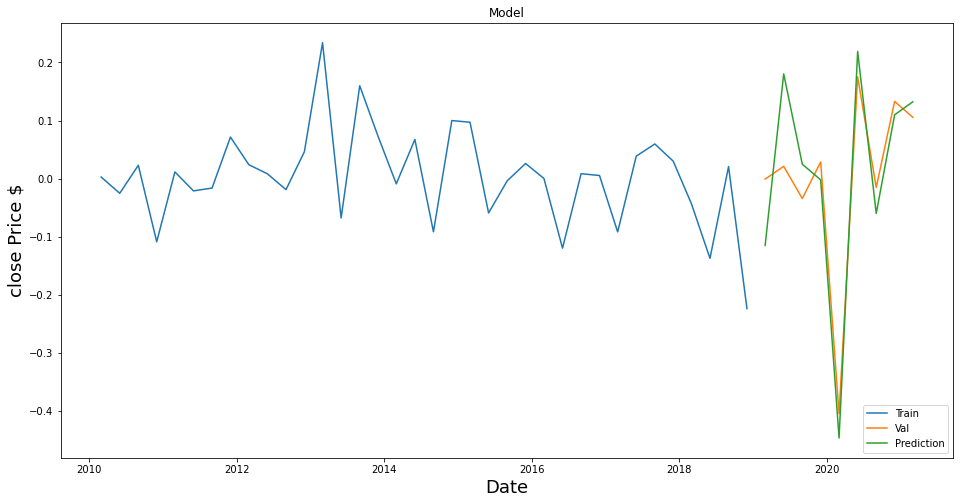

In [212]:

train_x = X[:int(0.8*len(X))]
train_y = Y[:int(0.8*len(Y))]

test_x = X[int(0.8*len(X)):]
test_y = Y[int(0.8*len(Y)):]

y_pred = est.predict(test_x)

df=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})
df.index = df.index.to_timestamp()
train_y.index = train_y.index.to_timestamp()
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('close Price $',fontsize=18)
plt.plot(train_y)
plt.plot(df['Predicted'])
plt.plot(df['Actual'])
plt.legend(['Train','Val','Prediction'],loc='lower right')

In [213]:
#use efficient columns (VIF less than 20)

X = data[efficient_col].iloc[:len(data)-1] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = data['log_return'].iloc[:-1]
X = sm.add_constant(X)
est = sm.OLS(Y, X.astype(float)).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                    0.6304
Date:                Thu, 05 Aug 2021   Prob (F-statistic):              0.678
Time:                        15:17:13   Log-Likelihood:                 35.407
No. Observations:                  44   AIC:                            -58.81
Df Residuals:                      38   BIC:                            -48.11
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1366      0.093     -1.473      0.149      -0.324       0.051
BasicEPS       0.0015      0.006      0.251      0.803      -0.010       0.013
volume       3.21e-11   3.52e-11      0.913      0.367   -3.91e-11    1.03e-10
PeRatio        0.0105      0.007      1.484      0.146      -0.004       0.025
PegRatio       0.0559      0.127      0.441      0.662      -0.201       0.313
PbRatio        0.0005      0.002      0.276      0.784      -0.003       0.004
==============================================================================
Omnibus:                       18.539   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.671
Skew:                          -1.144   Prob(JB):                     8.05e-08
Kurtosis:                       6.548   Cond. No.                     5.25e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [214]:
# use random forest model
train_x = X[:int(0.8*len(X))]
train_y = Y[:int(0.8*len(Y))]

test_x = X[int(0.8*len(X)):]
test_y = Y[int(0.8*len(Y)):]


from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 50)
regressor.fit(train_x, train_y)


RandomForestRegressor(n_estimators=1000, random_state=50)

In [215]:
y_pred = regressor.predict(test_x)
df=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})
df

Actual  Predicted
date                        
2018-12 -0.223704  -0.016158
2019-03 -0.114980  -0.039692
2019-06  0.180300  -0.058832
2019-09  0.024776   0.019233
2019-12 -0.002090   0.022769
2020-03 -0.446451   0.081589
2020-06  0.218944   0.084361
2020-09 -0.060002   0.084361
2020-12  0.109809   0.086355

In [216]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.15364535435340557
Mean Squared Error: 0.04721178826383006
Root Mean Squared Error: 0.21728273807145854


In [217]:
errors = abs(y_pred - test_y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 0.15 degrees.
Accuracy: 263.2 %.


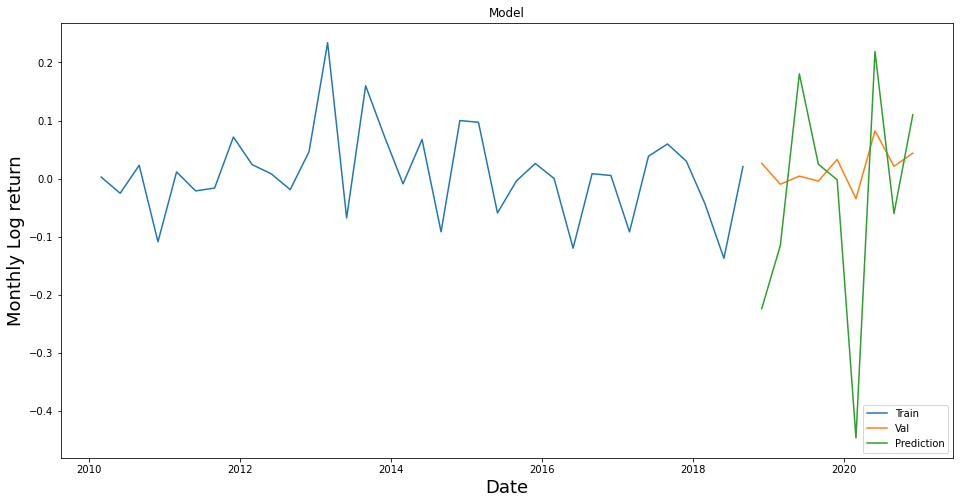

In [219]:
train_x = X[:int(0.8*len(X))]
train_y = Y[:int(0.8*len(Y))]

test_x = X[int(0.8*len(X)):]
test_y = Y[int(0.8*len(Y)):]

y_pred = est.predict(test_x)

df=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})
df.index = df.index.to_timestamp()
train_y.index = train_y.index.to_timestamp()
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Monthly Log return',fontsize=18)
plt.plot(train_y)
plt.plot(df['Predicted'])
plt.plot(df['Actual'])
plt.legend(['Train','Val','Prediction'],loc='lower right')

In [ ]:

# all factors
test_data = data[['OperatingRevenue', 'CostOfRevenue', 'GrossProfit', 'OperatingExpense',
       'SellingGeneralAndAdministration', 'GeneralAndAdministrativeExpense',
       'SalariesAndWages', 'RentAndLandingFees', 'OtherGandA',
       'SellingAndMarketingExpense',
       'DepreciationAmortizationDepletionIncomeStatement',
       'DepreciationAndAmortizationInIncomeStatement',
       'OtherOperatingExpenses', 'OperatingIncome',
       'NetNonOperatingInterestIncomeExpense', 'InterestIncomeNonOperating',
       'InterestExpenseNonOperating', 'OtherIncomeExpense',
       'SpecialIncomeCharges', 'RestructuringAndMergernAcquisition',
       'ImpairmentOfCapitalAssets', 'OtherSpecialCharges',
       'OtherNonOperatingIncomeExpenses', 'PretaxIncome', 'TaxProvision',
       'NetIncomeCommonStockholders', 'NetIncome',
       'NetIncomeIncludingNoncontrollingInterests',
       'NetIncomeContinuousOperations', 'DilutedNIAvailtoComStockholders',
       'BasicEPS', 'DilutedEPS', 'BasicAverageShares', 'DilutedAverageShares',
       'TotalOperatingIncomeAsReported', 'RentExpenseSupplemental',
       'TotalExpenses', 'NetIncomeFromContinuingAndDiscontinuedOperation',
       'NormalizedIncome', 'InterestIncome', 'InterestExpense',
       'NetInterestIncome', 'EBIT', 'ReconciledCostOfRevenue',
       'ReconciledDepreciation',
       'NetIncomeFromContinuingOperationNetMinorityInterest',
       'TotalUnusualItemsExcludingGoodwill', 'TotalUnusualItems',
       'NormalizedEBITDA', 'TaxRateForCalcs', 'TaxEffectOfUnusualItems',
        'adjclose', 'volume', 'MarketCap',
       'EnterpriseValue', 'PeRatio', 'ForwardPeRatio', 'PegRatio', 'PsRatio',
       'PbRatio', 'EnterprisesValueRevenueRatio',
       'EnterprisesValueEBITDARatio',
]]

In [ ]:
test_data = data[['OperatingRevenue', 'CostOfRevenue', 'OperatingExpense',
'NetNonOperatingInterestIncomeExpense', 
        'TaxProvision','NetIncome',
       'BasicEPS',  'BasicAverageShares', 
       'TotalExpenses', 
       'NormalizedIncome', 'InterestIncome', 'InterestExpense',
       'NetInterestIncome', 'EBIT',  
       'TotalUnusualItems',
        'TaxEffectOfUnusualItems',
        'volume', 'MarketCap',
       'EnterpriseValue', 'PeRatio', 'PegRatio', 'PsRatio',
       'PbRatio','GDP', 'Inflation',
       'ExchangeRate', 'adjclose'
       
    ]]